In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from configs.config import *
from configs.policies import *
from configs.state_updates import *

from cadCAD.configuration import append_configs
from cadCAD.configuration.utils import bound_norm_random, ep_time_step, config_sim
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

from cadCAD import configs
np.random.seed(42)

n_timesteps = 50000
simulation_parameters = {
    'T': range(n_timesteps),
    'N': 1,
    'M': {}
}

config = Configuration(initial_state=initial_conditions,
                   partial_state_update_blocks=partial_state_update_blocks,
                   sim_config=simulation_parameters
                  )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config])

raw_result, tensor = executor.execute()
rev = pd.DataFrame(raw_result)

#Now, we'll run the simulations again, this time disalowing market makers to change their votes.
partial_state_update_blocks[0]['policies'].pop('revoting_maker', None)
partial_state_update_blocks[0]['variables'].pop('votes', None)

config = Configuration(initial_state=initial_conditions, 
                       partial_state_update_blocks=partial_state_update_blocks,
                       sim_config=simulation_parameters
                      )


executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
norev = pd.DataFrame(raw_result)


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7fce5c297cc0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7fce5c297cc0>]

                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7fce22d1be80>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7fce22d1be80>]


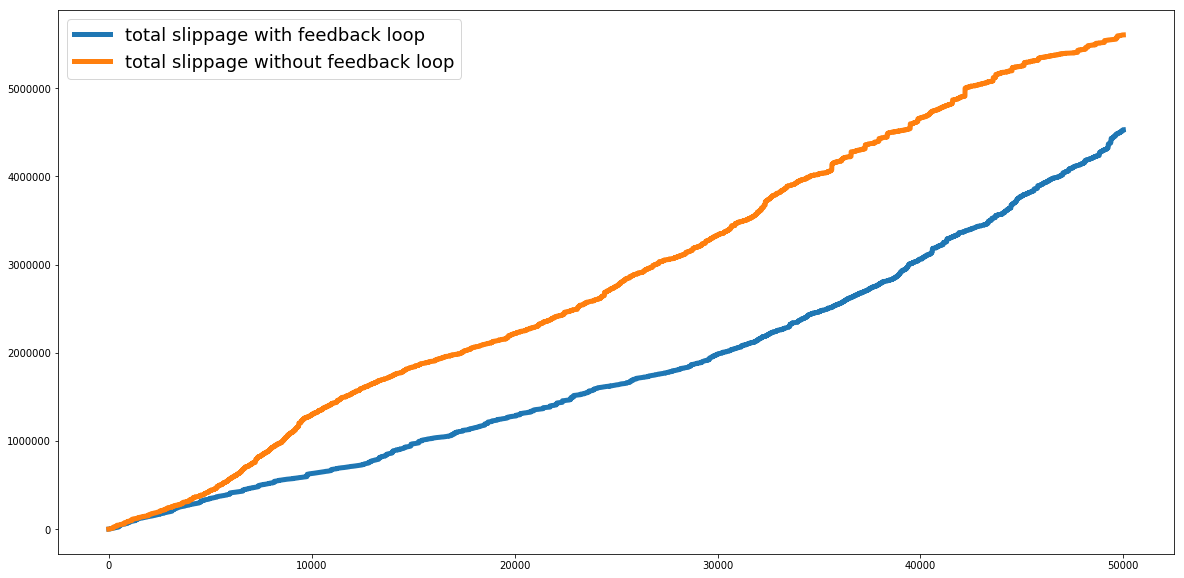

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

plt.plot(rev['accumulated_slippage'].values, label = 'total slippage with feedback loop', linewidth = 5)
plt.plot(norev['accumulated_slippage'].values, label = 'total slippage without feedback loop', linewidth = 5)
plt.legend(fontsize = 18)